# Model definition

Assumption:
- Isotherms and isobars conditions.
- Perfect mixing.
- No mass loss.
- $T_r = 65°C$

## Reactions: 

Reaction 1:
$$
CA + HP \rightarrow E_p +W
$$

Reaction 2:
$$
2 \times HP \rightarrow W + O
$$

Reaction 3:
$$
E_p + W \rightarrow RO
$$

## kinetics

$$
R_1 = K_1 \times C_{CA} \times C_{HP}
$$

$$
R_2 = K_2 \times C_{HP}^2
$$

$$
R_3 = K_3 \times C_{E_p} \times C_W
$$

## Mass balance

CA:
$$
\frac{dC_{CA}}{dt} = - R_1
$$

HP:
$$
\frac{dC_{HP}}{dt} = - R_1 - 2R_2
$$

Ep:
$$
\frac{dC_{Ep}}{dt} = R_1 - R_3
$$

RO:
$$
\frac{dC_{RO}}{dt} = R_3
$$

W:
$$
\frac{dC_{W}}{dt} = R_1 + 2 R_2 - R_3
$$

## Heat balance 
$$
q_{rx} = -(R_1 \Delta H_1 + R_2 \Delta H_2 + R_3 \Delta H_3) \frac{m_r}{\rho}
$$

with: 
- $\Delta H_i$ enthalpie
- $m_r$ masse
- $\rho$ masse volumique



In [64]:
# utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

In [65]:
# Constants
k01_100 = 5.25E-5   # L/mol/s
Ea1 = 57000   # J/mol
H1 = -10000   # Reaction enthalpy J/mol
k02_100 = 7E-8  
Ea2 = 220000 
H2 = -95000 
k03_100 = 0.3E-8  
Ea3 = 250000 
H3 = -5000
Rg = 8.314   # J/mol/K
UA = 10   # Global heat transfer coefficient W/K
Cpr = 2500   # Heat capacity of the reaction mixture J/kg/K
mr = 90   # Mass of the reaction mixture in kg
rho = 1   # Density of water
Tr0 = 65 + 273.15   # Temperature of the jacket or initial temperature
kla = 0.23   # Mass transfer coefficient in s^-1
Vheadspace = 50 / 1000   # in m^3 
PN2 = 10 * 100000   # Initial pressure 

In [66]:
# definition of the ODE   
def df(t, c):
    CA, HP, Ep, RO, W, O2_liq, n02_gas = c
    k1 = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    k2 = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    k3 = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    R1 = k1 * CA * HP
    R2 = k2 * (HP**2)
    R3 = k3 * Ep * W
    O2_star = 0.001473 * np.exp(-0.008492 * (Tr0 - 273.15))
    dCAdt = -R1
    dHPdt = -R1 - 2 * R2
    dEpdt = R1 - R3
    dROdt = R3
    dWdt = R1 + 2 * R2 - R3
    dO2_liqdt = R2 - kla * (O2_liq - O2_star)
    dn02_gasdt = kla * (mr / rho) * (O2_liq - O2_star)
    return [dCAdt, dHPdt, dEpdt, dROdt, dWdt, dO2_liqdt, dn02_gasdt]

In [67]:
# Initial conditions
c0 = [7.26, 9.15, 0, 0, 7.41, 0, 0] # CA0 HP0 Ep0 RO0 W0 O2_liq0 T0 nO2_gas0
t_span = (0, 50000) # from 0 to 50000 seconds 
t_eval = np.linspace(0, 50000, 501) # points at which to store the solution


In [68]:
# Solver
sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval)

# Extract solution
t = sol.t
CA_1 = sol.y[0]
HP_1 = sol.y[1]
Ep_1 = sol.y[2]
W_1 = sol.y[4]
RO_1 = sol.y[3]
O2_liq_1 = sol.y[5]

# Calculate Vapor pressure of the mixture using Raoult law
VP_W=(10**(11.008-(2239.7/Tr0)))
VP_HP=(10**(9.9669-(2175/Tr0)))
VP_CA=(10**(9.7621-(1511.9/Tr0)))
VP_Ep=(10**(10.671-(2182.2/Tr0)))
VP_Diol=(10**(12.266-(3455.4/Tr0)))
VP_mix=((W_1*VP_W+HP_1*VP_HP+CA_1*VP_CA+Ep_1*VP_Ep+RO_1*VP_Diol)/(W_1+HP_1+CA_1+Ep_1+RO_1+O2_liq_1))/100000 #Express in bar


# Rates
k1_T = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate1 = k1_T * CA_1 * HP_1
k2_T = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate2 = k2_T * (HP_1**2)
k3_T = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate3 = k3_T * Ep_1 * W_1
qrx=-rate1*H1*(mr/rho)-rate2*H2*(mr/rho)-rate3*H3*(mr/rho)
Tj=((qrx/(-UA))+Tr0)-273.15


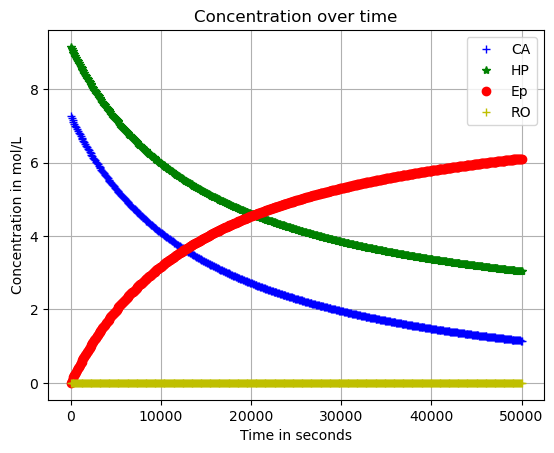

In [69]:
# Plot results
plt.figure(1)
plt.title("Concentration over time")
plt.plot(t, CA_1, 'b+', label='CA')
plt.plot(t, HP_1, 'g*', label='HP')
plt.plot(t, Ep_1, 'ro', label='Ep')
plt.plot(t, RO_1, 'y+', label='RO')
plt.grid(True) 
plt.xlabel("Time in seconds")
plt.ylabel("Concentration in mol/L")
plt.legend(loc='upper right')
plt.show()

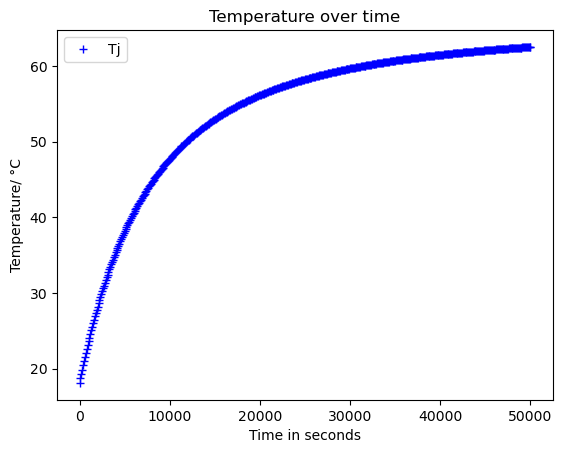

In [70]:
plt.figure(2)
plt.plot(t, Tj, 'b+', label='Tj')
plt.title("Temperature over time")
plt.xlabel("Time in seconds")
plt.ylabel("Temperature/ °C")
plt.legend()
plt.show()

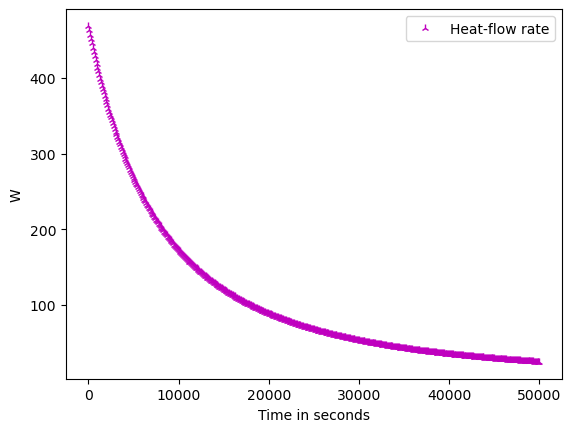

In [71]:
plt.figure(3)
plt.plot(t, qrx, 'm2', label='Heat-flow rate')
plt.xlabel("Time in seconds")
plt.ylabel("W")
plt.legend()
plt.show()

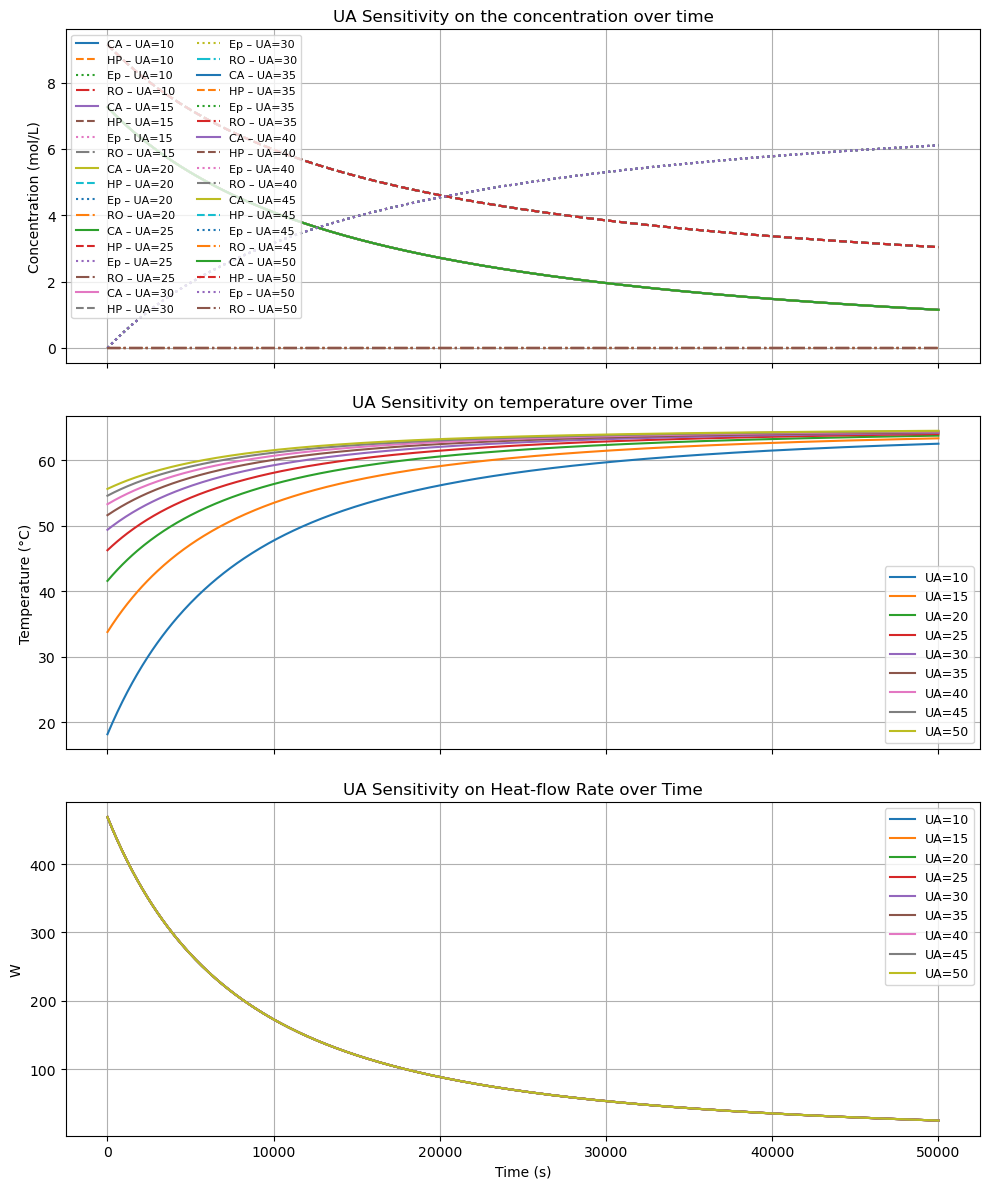

In [72]:
# Etude de sensibilité de UA
UA_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
for UA_var in UA_values:
    sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval)

    t = sol.t
    CA = sol.y[0]
    HP = sol.y[1]
    Ep = sol.y[2]
    RO = sol.y[3]
    W = sol.y[4]
    
    # Rates
    rate1 = k1_T * CA_1 * HP_1
    rate2 = k2_T * (HP_1**2)
    rate3 = k3_T * Ep_1 * W_1
    
    qrx=-rate1*H1*(mr/rho)-rate2*H2*(mr/rho)-rate3*H3*(mr/rho)
    Tj=((qrx/(-UA_var))+Tr0)-273.15

    # Concentrations 
    axs[0].plot(t, CA, label=f'CA – UA={UA_var}')
    axs[0].plot(t, HP, '--', label=f'HP – UA={UA_var}')
    axs[0].plot(t, Ep, ':', label=f'Ep – UA={UA_var}')
    axs[0].plot(t, RO, '-.', label=f'RO – UA={UA_var}')

    # Tj 
    axs[1].plot(t, Tj, label=f'UA={UA_var}')

    # qrx
    axs[2].plot(t, qrx, label=f'UA={UA_var}')

axs[0].set_title("UA Sensitivity on the concentration over time")
axs[0].set_ylabel("Concentration (mol/L)")
axs[0].grid(True)

axs[1].set_title("UA Sensitivity on temperature over Time")
axs[1].set_ylabel("Temperature (°C)")
axs[1].grid(True)

axs[2].set_title("UA Sensitivity on Heat-flow Rate over Time")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("W")
axs[2].grid(True)

axs[0].legend(ncol=2, fontsize=8)
axs[1].legend(fontsize=9)
axs[2].legend(fontsize=9)

plt.tight_layout()
plt.show()


## Model including Pressure effects

We consider isothermal coditions at a constant reaction temperature of $T_r=65°C$

Assumptions:
- Batch reactor
- No mass loss

### The material balances in the liquid phase

$$
\frac{C_{O_2,liq}}{dt} = R_2 - K_{LG,O_2}(C_{O_2,liq} - C_{O_2,liq}^*)
$$

### The mass transfer of $O_2$ from liquid to gas phase 
$$
\frac{dn_{O_2,gas}}{dt} = K_{LG} V_{liq} (C_{O_2,liq} - C_{O_2,liq}^*)
$$

### The heat flow rate 
$$
q_{rx} = - R_1 V_{liq} \Delta H_{r1} - R_2 V_{liq} \Delta H_{r2} - R_3 V_{liq} \Delta H_{r3} 
$$
As we work under isothermal conditions, the accumulated heat flow rate $q_{acc}$ in the reaction mixture is equal to zero:
$$
q_{acc} = q_{rx} + q_{exch}
$$

Thus, the jacket temperature follow the equation:
$$
T_j = \frac{-q_{rx}}{UA} + T_R
$$
### Vapor pressure of the liquid mixture
Raoult's law:
$$
P_{vap}(t) = \sum_i x_i(t) P_i^{sat}(T)
$$
where $x_i$ are the liquid phase mole fractions and $P_i^{sat}(T)$ are the saturated vapor pressures of the pure components. Thus, we can verify whether the boiling point is reached during the reaction. 



In [75]:
# Initial conditions
c0 = [7.26, 9.15, 0, 0, 7.41, 0, 0] # CA0 HP0 Ep0 RO0 W0 O2_liq0 T0 nO2_gas0
t_span = (0, 50000) # from 0 to 50000 seconds 
t_eval = np.linspace(0, 50000, 501) # points at which to store the solution

# Solver
sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval)

# Extract solution
t = sol.t
CA_1 = sol.y[0]
HP_1 = sol.y[1]
Ep_1 = sol.y[2]
W_1 = sol.y[4]
RO_1 = sol.y[3]
O2_liq_1 = sol.y[5]
n02_gas_1 = sol.y[6]
nN2_gas_1 = (PN2 * Vheadspace) / (Rg * Tr0) # N2 at t=0

# Calculate Pressure considering the condition
P_1 = [((n02_gas + nN2_gas_1) * Rg * Tr0 / Vheadspace) / 100000 if n02_gas >= 0 else (nN2_gas_1 * Rg * Tr0 / Vheadspace) / 100000 for n02_gas in n02_gas_1]

# Calculate Vapor pressure of the mixture using Raoult law
VP_W=(10**(11.008-(2239.7/Tr0)))
VP_HP=(10**(9.9669-(2175/Tr0)))
VP_CA=(10**(9.7621-(1511.9/Tr0)))
VP_Ep=(10**(10.671-(2182.2/Tr0)))
VP_Diol=(10**(12.266-(3455.4/Tr0)))
VP_mix=((W_1*VP_W+HP_1*VP_HP+CA_1*VP_CA+Ep_1*VP_Ep+RO_1*VP_Diol)/(W_1+HP_1+CA_1+Ep_1+RO_1+O2_liq_1))/100000 #Express in bar

qrx=-rate1*H1*(mr/rho)-rate2*H2*(mr/rho)-rate3*H3*(mr/rho)
Tj=((qrx/(-UA))+Tr0)-273.15



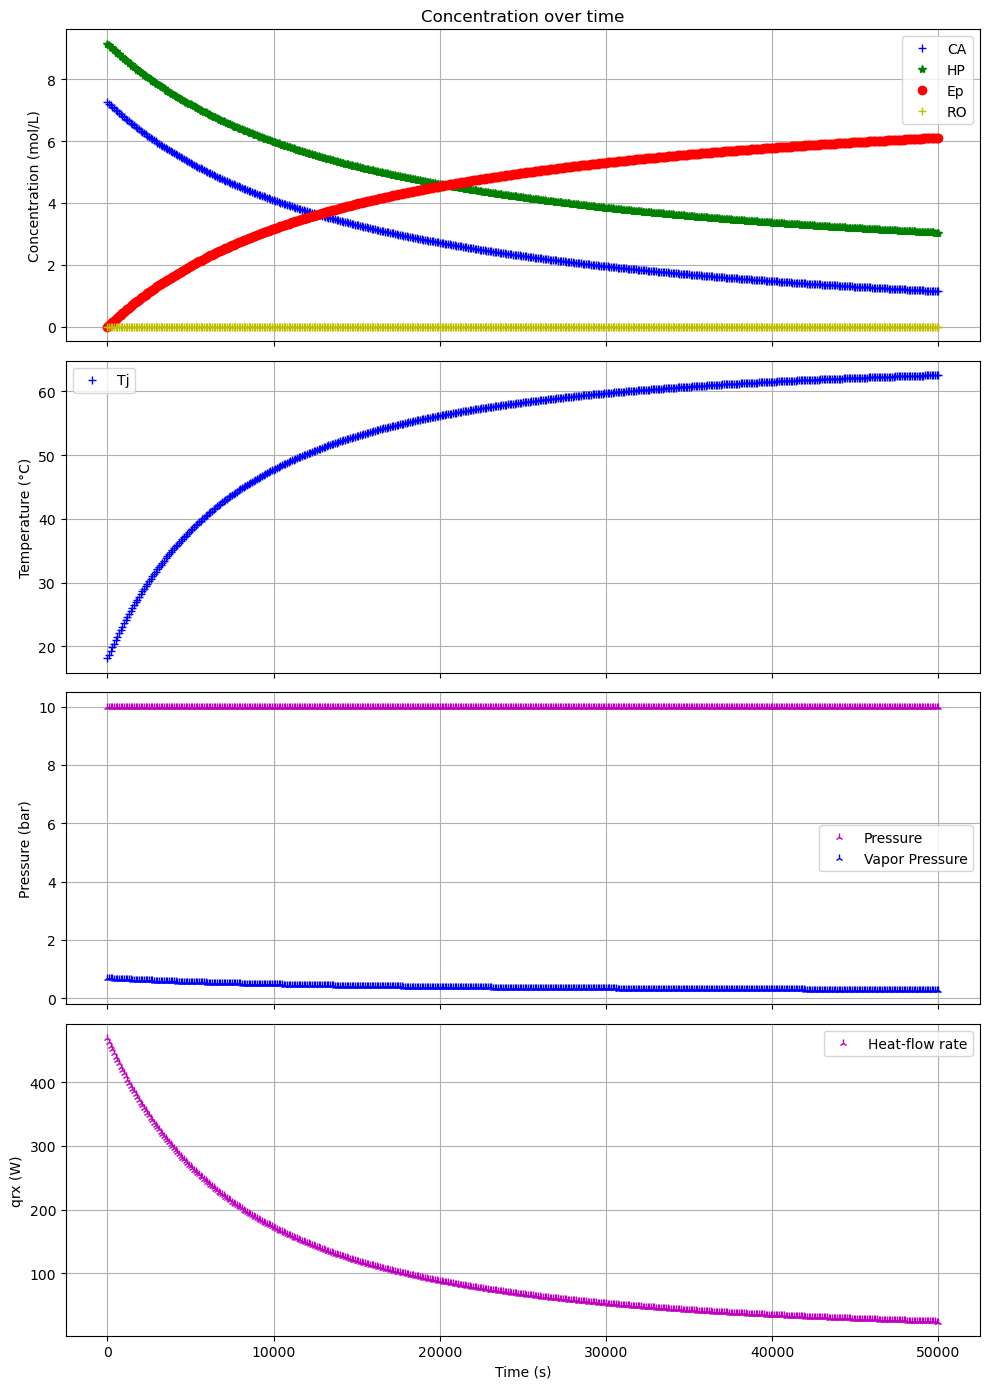

In [76]:
fig, axs = plt.subplots(4, 1, figsize=(10, 14), sharex=True)

# Concentrations
axs[0].plot(t, CA_1, 'b+', label='CA')
axs[0].plot(t, HP_1, 'g*', label='HP')
axs[0].plot(t, Ep_1, 'ro', label='Ep')
axs[0].plot(t, RO_1, 'y+', label='RO')
axs[0].set_title("Concentration over time")
axs[0].set_ylabel("Concentration (mol/L)")
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Temperature 
axs[1].plot(t, Tj, 'b+', label='Tj')
axs[1].set_ylabel("Temperature (°C)")
axs[1].legend()
axs[1].grid(True)

# Pressure
axs[2].plot(t, P_1, 'm2', label='Pressure')
axs[2].plot(t, VP_mix, 'b2', label='Vapor Pressure')
axs[2].set_ylabel("Pressure (bar)")
axs[2].legend()
axs[2].grid(True)

# Heat-flow rate
axs[3].plot(t, qrx, 'm2', label='Heat-flow rate')
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("qrx (W)")
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


Both models give similar results. The vapor pressure of the reaction mixture is lower than the pressure in the reactor which mean that the pressure is constant during the reaction. 

## Liquid gas mass transfer 
In the previous section, the model developed is extended to be more realistic. Thus, we add several assumptions:
- Isothermal conditions.
- The liquid and gas phase have the same temperature.
- The liquid phase volume varies with time due to evaporation and gas liquid mass transfer.
- The liquid density is constant.
- Batch mode.

In this stage, we consider the mass exchanges between liquid and gas phases. Oxygen is transferred to the gas phase and the liquid mass decreases over time which will have influence on the evolution of pressure in reactor. 

We consider double film model. Thus, the mass transfer between the liquid and gas phases is not instantaneous. As a result, the mass flux crossing the liquid film is equal to the mass flux crossing the gas film: 

$$
K_{liq} a (C_{x,liq} - C_{x,liq}^*) V_{liq} = K_{gas} a (C_{x,gas} - C_{x,gas}^*) V_{gas} 
$$
where:
- $C_{x,liq}^*$ is the solubility of compound $x$ in the liquid phase.
- $C_{x,gas}^*$ is the concentration of $x$ in the gas phase and it's equal to:
$$
C_{x,gas}^*=\frac{VP_x(T)}{R_g T_{gas phase}}
$$
where:
- $VP_x(T)$ is the saturated vapor pressure of compound $x$ at temperature $T$.
- $R_g$ is the universal gas constant.
- $T_{gas phase}$ is the temperature of gas phase.

Oxygen does not have a saturated vapor pressure so the solubility term was used. For water, chlorinated allyl, hydrogen peroxide, epichlorohydrin, diol and water the saturated vapor pressure was applied.

### The variation of liquid mass over time
$$
\begin{aligned}
\frac{d m_{liq}}{dt}
=&
- k_{gas}\, a\, V_{gas}
\Big[
\left(C_{CA,gas}^{*}-C_{CA,gas}\right) M_{CA}
+
\left(C_{HP,gas}^{*}-C_{HP,gas}\right) M_{HP}
\\
&\quad
+
\left(C_{W,gas}^{*}-C_{W,gas}\right) M_{W}
+
\left(C_{Epi,gas}^{*}-C_{Epi,gas}\right) M_{Epi}
+
\left(C_{Diol,gas}^{*}-C_{Diol,gas}\right) M_{Diol}
\Big]
\\
&\quad
- k_{liq}\, a\, V_{liq}
\left(C_{O_2,liq}-C_{O_2,liq}^{*}\right) M_{O_2}
\end{aligned}
$$

for all species excepting oxygen the value of $K_{gas} a$ is the same and equals to $3.5 s^{-1}$ and for oxygen is $2.3 s^{-1}$. We neglect the evaporation of diol, so the variation of liquid phase is given by:

$$
\begin{aligned}
\frac{d m_{liq}}{dt}
=&
- k_{gaz}\, a\, V_{gaz}
\Bigg[
\left(
\frac{PVS_{CA}\!\left(T_{gaz}\right)}{R\,T_{gaz}}
-
C_{CA,gaz}
\right) M_{CA}
\\
&\quad
-
\left(
\frac{PVS_{PH}\!\left(T_{gaz}\right)}{R\,T_{gaz}}
-
C_{PH,gaz}
\right) M_{PH}
\\
&\quad
-
\left(
\frac{PVS_{W}\!\left(T_{gaz}\right)}{R\,T_{gaz}}
-
C_{W,gaz}
\right) M_{W}
\\
&\quad
-
\left(
\frac{PVS_{Epi}\!\left(T_{gaz}\right)}{R\,T_{gaz}}
-
C_{Epi,gaz}
\right) M_{Epi}
\Bigg]
\\
&\quad
- k_{liq}\, a\, V_{liq}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}\!\left(T_{liq}\right)
\right) M_{O_2}
\end{aligned}
$$

To shift from the volume of the liquid phase to the mass, we use: 
$$
\frac{dV_{liq}}{dt} = \frac{1}{\rho} \frac{d(m_{liq})}{dt}
$$

### Material balance

CA: 
$$
\begin{aligned}
\frac{d n_{CA,liq}}{dt}
&=
\frac{d\!\left(C_{CA,liq}\,V_{liq}\right)}{dt}
=
- R_1\,V_{liq}
-
k_{gas}\,a
\left(C_{CA,gas}^{*}-C_{CA,gas}\right)
V_{gas}
\\[6pt]
\Longleftrightarrow \qquad
\frac{d C_{CA,liq}}{dt}
&=
- R_1
-
k_{gas}\,a
\left(
\frac{VP_{CA}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{CA,gas}
\right)
\frac{V_{gas}}{V_{liq}}
\\
&\quad
-
C_{CA,liq}\,
\frac{1}{m_{liq}}
\Bigg[
- k_{gas}\,a\,V_{gas}
\Big(
\left(
\frac{VP_{CA}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{CA,gas}
\right) M_{CA}
\\
&\qquad
-
\left(
\frac{VP_{HP}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{HP,gas}
\right) M_{HP}
-
\left(
\frac{VP_{W}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{W,gas}
\right) M_{W}
\\
&\qquad
-
\left(
\frac{VP_{Epi}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{Epi,gas}
\right) M_{Epi}
\Big)
\\
&\qquad
-
k_{liq}\,a\,
\frac{m_{liq}}{\rho}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}\!\left(T_{liq}\right)
\right)
M_{O_2}
\Bigg]
\end{aligned}
$$

$$
\frac{d n_{CA,gas}}{dt}
=
k_{gas}\, a\, V_{gas}
\left(
\frac{VP_{CA}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{CA,gas}
\right)
$$


HP: 
$$
\begin{aligned}
\frac{d C_{HP,liq}}{dt}
=&
- R_1
- 2\,R_2
\\
&\;
- k_{gaz}\,a
\left(
\frac{VP_{HP}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{HP,gas}
\right)
\frac{V_{gas}}{V_{liq}}
\\
&\;
-
C_{HP,liq}\,
\frac{1}{m_{liq}}
\Bigg[
- k_{gaz}\,a\,V_{gas}
\Big(
\left(
\frac{VP_{CA}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{CA,gas}
\right) M_{CA}
\\
&\qquad
-
\left(
\frac{VP_{HP}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{HP,gas}
\right) M_{HP}
-
\left(
\frac{VP_{W}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{W,gas}
\right) M_{W}
\\
&\qquad
-
\left(
\frac{VP_{Epi}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{Epi,gas}
\right) M_{Epi}
\Big)
\\
&\qquad
-
k_{liq}\,a\,
\frac{m_{liq}}{\rho}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}\!\left(T_{liq}\right)
\right)
M_{O_2}
\Bigg]
\end{aligned}
$$

$$
\frac{d n_{HP,gas}}{dt}
=
k_{gas}\, a\, V_{gas}
\left(
\frac{VP_{HP}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{HP,gas}
\right)
$$


Ep:
$$
\begin{aligned}
\frac{d C_{Ep,liq}}{dt}
=&
R_1
-
R_3
\\
&\;
- k_{gaz}\,a
\left(
\frac{VP_{Ep}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{Ep,gas}
\right)
\frac{V_{gas}}{V_{liq}}
\\
&\;
-
C_{Ep,liq}\,
\frac{1}{m_{liq}}
\Bigg[
- k_{gaz}\,a\,V_{gaz}
\Big(
\left(
\frac{PVS_{CA}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{CA,gaz}
\right) M_{CA}
\\
&\qquad
-
\left(
\frac{PVS_{HP}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{HP,gaz}
\right) M_{HP}
-
\left(
\frac{PVS_{W}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{W,gaz}
\right) M_{W}
\\
&\qquad
-
\left(
\frac{PVS_{Epi}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{Epi,gaz}
\right) M_{Epi}
\Big)
\\
&\qquad
-
k_{liq}\,a\,
\frac{m_{liq}}{\rho}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}\!\left(T_{liq}\right)
\right)
M_{O_2}
\Bigg]
\end{aligned}
$$

$$
\frac{d n_{Ep,gas}}{dt}
=
k_{gas}\, a\, V_{gas}
\left(
\frac{VP_{Ep}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{Ep,gas}
\right)
$$


RO:
$$
\begin{aligned}
\frac{d C_{RO,liq}}{dt}
=&
R_3
\\
&\;
-
C_{RO,liq}\,
\frac{1}{m_{liq}}
\Bigg[
- k_{gaz}\,a\,V_{gaz}
\Big(
\left(
\frac{PVS_{CA}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{CA,gaz}
\right) M_{CA}
\\
&\qquad
-
\left(
\frac{PVS_{HP}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{HP,gaz}
\right) M_{HP}
-
\left(
\frac{PVS_{W}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{W,gaz}
\right) M_{W}
\\
&\qquad
-
\left(
\frac{PVS_{Epi}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{Epi,gaz}
\right) M_{Epi}
\Big)
\\
&\qquad
-
k_{liq}\,a\,
\frac{m_{liq}}{\rho}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}\!\left(T_{liq}\right)
\right)
M_{O_2}
\Bigg]
\end{aligned}
$$

W: 
$$
\begin{aligned}
\frac{d C_{W,liq}}{dt}
=&
R_1
+
2\,R_2
-
R_3
\\
&\;
- k_{gaz}\,a
\left(
\frac{VP_{W}\!\left(T_{gas}\right)}{R_g\,T_{gas}}
-
C_{W,gas}
\right)
\frac{V_{gas}}{V_{liq}}
\\
&\;
-
C_{W,liq}\,
\frac{1}{m_{liq}}
\Bigg[
- k_{gaz}\,a\,V_{gaz}
\Big(
\left(
\frac{PVS_{CA}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{CA,gaz}
\right) M_{CA}
\\
&\qquad
-
\left(
\frac{PVS_{PH}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{PH,gaz}
\right) M_{HP}
-
\left(
\frac{PVS_{W}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{W,gaz}
\right) M_{W}
\\
&\qquad
-
\left(
\frac{PVS_{Epi}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{Epi,gaz}
\right) M_{Epi}
\Big)
\\
&\qquad
-
k_{liq}\,a\,
\frac{m_{liq}}{\rho}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}\!\left(T_{liq}\right)
\right)
M_{O_2}
\Bigg]
\end{aligned}
$$

$O_2$:
$$
\begin{aligned}
\frac{d C_{O_2,liq}}{dt}
=&
R_2
\\
&\;
-
k_{LG,O_2}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}
\right)
\\
&\;
-
C_{O_2,liq}\,
\frac{1}{m_{liq}}
\Bigg[
- k_{gaz}\,a\,V_{gaz}
\Big(
\left(
\frac{PVS_{CA}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{CA,gaz}
\right) M_{CA}
\\
&\qquad
-
\left(
\frac{PVS_{PH}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{PH,gaz}
\right) M_{HP}
-
\left(
\frac{PVS_{W}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{W,gaz}
\right) M_{W}
\\
&\qquad
-
\left(
\frac{PVS_{Epi}\!\left(T_{gaz}\right)}{R_g\,T_{gaz}}
-
C_{Epi,gaz}
\right) M_{Epi}
\Big)
\\
&\qquad
-
k_{liq}\,a\,
\frac{m_{liq}}{\rho}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}\!\left(T_{liq}\right)
\right)
M_{O_2}
\Bigg]
\end{aligned}
$$

$$
\frac{d n_{O_2,gas}}{dt}
=
k_{LG,O_2}\, V_{liq}
\left(
C_{O_2,liq}
-
C_{O_2,liq}^{*}
\right)
$$





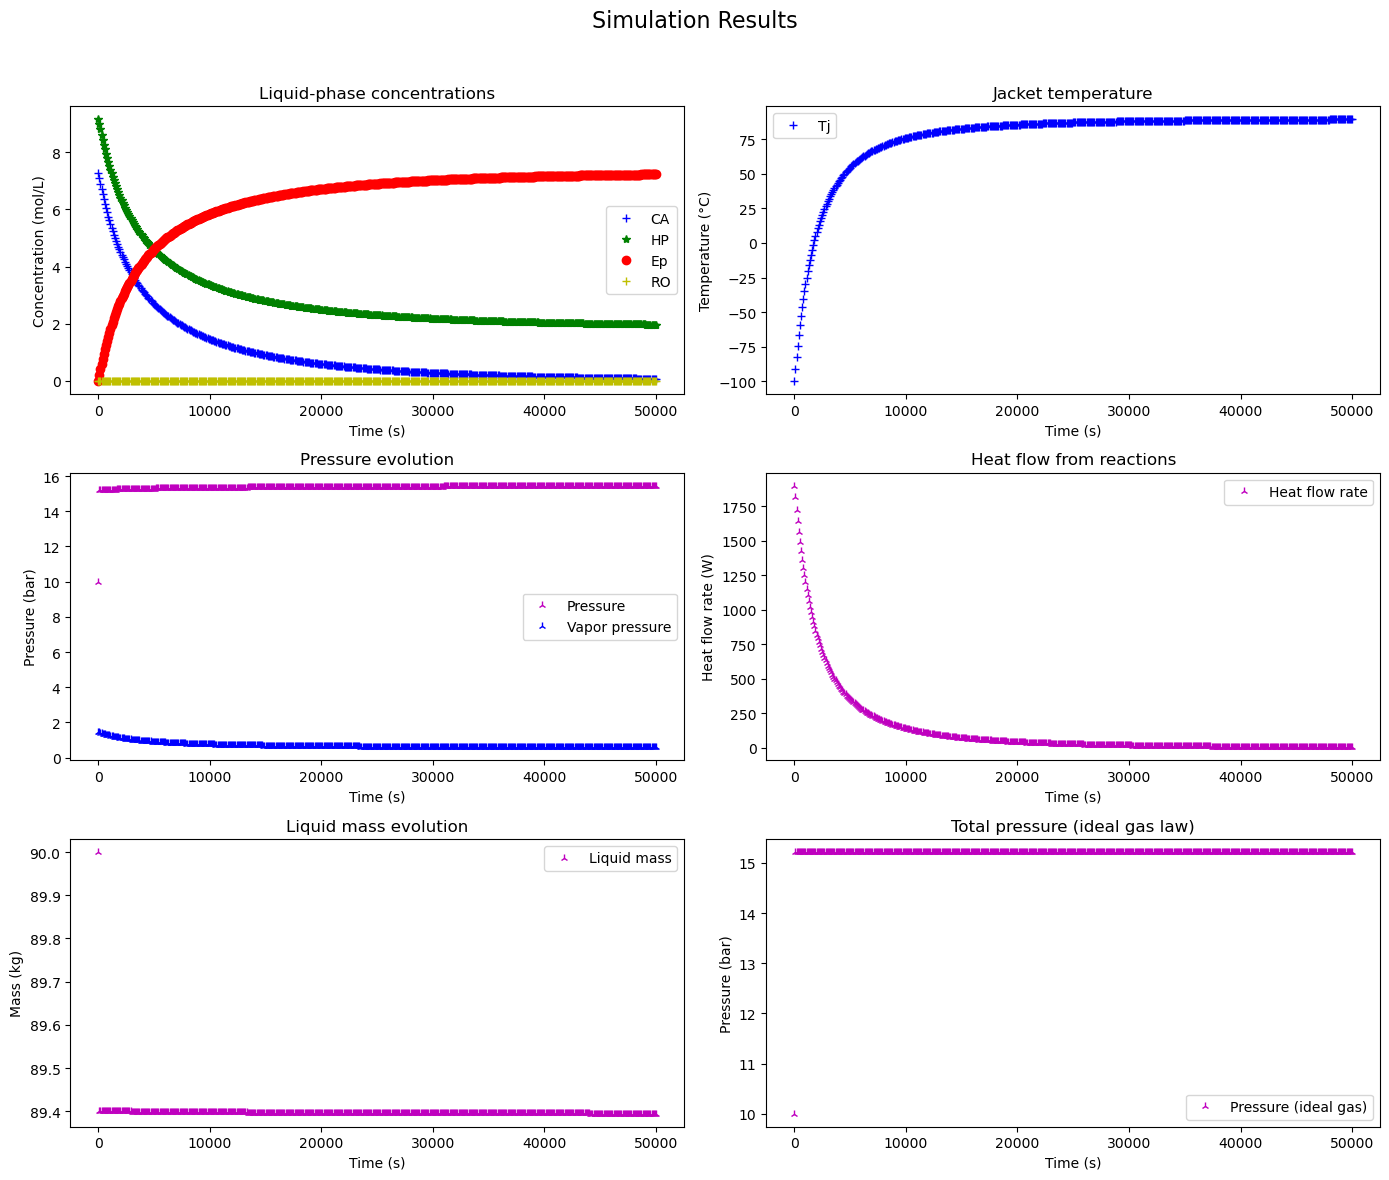

In [79]:
# addionnal parameters 
kla2=3.5

# ODE definition 
def df(t, c):
    CA, HP, Ep, RO, W, O2_liq, n02_gas, nCA_gas, nHP_gas, nEp_gas, nW_gas, mr, P = c
    k1 = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    k2 = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    k3 = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr0) - (1 / 373.15))))
    R1 = k1 * CA * HP
    R2 = k2 * (HP**2)
    R3 = k3 * Ep * W
    O2_star = 0.001473 * np.exp(-0.008492 * (Tr0 - 273.15))
    W_star_g=(10**(11.008-(2239.7/Tr0)))/(Rg*Tr0) #en mol/m3
    HP_star_g=(10**(9.9669-(2175/Tr0)))/(Rg*Tr0) #en mol/m3
    CA_star_g=(10**(9.7621-(1511.9/Tr0)))/(Rg*Tr0) #en mol/m3
    Ep_star_g=(10**(10.671-(2182.2/Tr0)))/(Rg*Tr0) #en mol/m3
    Diol_star_g=(10**(12.266-(3455.4/Tr0)))/(Rg*Tr0) #en mol/m3
    
    # Adjust kla based on O2_liq - O2_star condition
    kla_effective = kla if O2_liq - O2_star >= 0 else 0
    dO2_liqdt = R2 - kla_effective * (O2_liq - O2_star)
    dn02_gasdt = kla_effective * (mr / rho) * (O2_liq - O2_star)
    
    dCAdt = -R1-(kla2*(CA_star_g-nCA_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(CA/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dHPdt = -R1 - 2 * R2-(kla2*(HP_star_g-nHP_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(HP/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dEpdt = R1 - R3-(kla2*(Ep_star_g-nEp_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(Ep/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dROdt = R3-(RO/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dWdt = R1 + 2 * R2 - R3-(kla2*(W_star_g-nW_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(W/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    
    dnCA_gasdt=Vheadspace*kla2*(CA_star_g-nCA_gas/Vheadspace)
    dnHP_gasdt=Vheadspace*kla2*(HP_star_g-nHP_gas/Vheadspace)
    dnEp_gasdt=Vheadspace*kla2*(Ep_star_g-nEp_gas/Vheadspace)
    dnW_gasdt=Vheadspace*kla2*(W_star_g-nW_gas/Vheadspace)
    dmrdt=-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3))
    dPdt=((Rg*Tr0)/Vheadspace)*((dnCA_gasdt)+(dnHP_gasdt)+(dnEp_gasdt)+dnW_gasdt)
    return [dCAdt, dHPdt, dEpdt, dROdt, dWdt, dO2_liqdt, dn02_gasdt, dnCA_gasdt, dnHP_gasdt, dnEp_gasdt, dnW_gasdt, dmrdt, dPdt]

# Initial conditions
c0 = [7.26, 9.15, 0, 0, 7.41, 0, 0, 0,0,0,0,90,PN2] # CA0 HP0 Ep0 RO0 W0 O2_liq0 T0 nO2_gas0..., nCA_gas, nHP_gas, nEp_gas, nRO_gas, nW_gas, mr
t_span = (0, 50000) # from 0 to 50000 seconds 
t_eval = np.linspace(0, 50000, 501) # points at which to store the solution

# Solver
sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval)

# Extract solution
t = sol.t
CA_1 = sol.y[0]
HP_1 = sol.y[1]
Ep_1 = sol.y[2]
W_1 = sol.y[4]
RO_1 = sol.y[3]
O2_liq_1 = sol.y[5]
n02_gas_1 = sol.y[6]
nCA_gas_1 = sol.y[7]
nHP_gas_1 = sol.y[8]
nEp_gas_1 = sol.y[9]
nW_gas_1 = sol.y[10]
nN2_gas_1 = (PN2 * Vheadspace) / (Rg * Tr0) # N2 at t=0
mr_1=sol.y[11]
Pressure=sol.y[12]/100000

# Calculate Pressure considering the condition
P_1 = ((n02_gas_1 + nCA_gas_1 + nHP_gas_1 + nEp_gas_1 + nW_gas_1+ nN2_gas_1) * Rg * Tr0 / Vheadspace) / 100000

# Calculate Vapor pressure of the mixture using Raoult law
VP_W=(10**(11.008-(2239.7/Tr0)))
VP_HP=(10**(9.9669-(2175/Tr0)))
VP_CA=(10**(9.7621-(1511.9/Tr0)))
VP_Ep=(10**(10.671-(2182.2/Tr0)))
VP_Diol=(10**(12.266-(3455.4/Tr0)))
VP_mix=((W_1*VP_W+HP_1*VP_HP+CA_1*VP_CA+Ep_1*VP_Ep+RO_1*VP_Diol)/(W_1+HP_1+CA_1+Ep_1+RO_1+O2_liq_1))/100000 #Express in bar

# Rates
k1_T = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate1 = k1_T * CA_1 * HP_1
k2_T = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate2 = k2_T * (HP_1**2)
k3_T = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate3 = k3_T * Ep_1 * W_1
qrx=-rate1*H1*(mr_1/rho)-rate2*H2*(mr_1/rho)-rate3*H3*(mr_1/rho)
Tj=((qrx/(-UA))+Tr0)-273.15

#plot 

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Simulation Results", fontsize=16)

# Concentrations 
axs[0, 0].plot(t, CA_1, 'b+', label='CA')
axs[0, 0].plot(t, HP_1, 'g*', label='HP')
axs[0, 0].plot(t, Ep_1, 'ro', label='Ep')
axs[0, 0].plot(t, RO_1, 'y+', label='RO')
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Concentration (mol/L)")
axs[0, 0].set_title("Liquid-phase concentrations")
axs[0, 0].legend()

# Jacket temperature 
axs[0, 1].plot(t, Tj, 'b+', label='Tj')
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Temperature (°C)")
axs[0, 1].set_title("Jacket temperature")
axs[0, 1].legend()

# Pressure & vapor pressure 
axs[1, 0].plot(t, P_1, 'm2', label='Pressure')
axs[1, 0].plot(t, VP_mix, 'b2', label='Vapor pressure')
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Pressure (bar)")
axs[1, 0].set_title("Pressure evolution")
axs[1, 0].legend()

# Heat flow rate 
axs[1, 1].plot(t, qrx, 'm2', label='Heat flow rate')
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Heat flow rate (W)")
axs[1, 1].set_title("Heat flow from reactions")
axs[1, 1].legend()

# Liquid mass 
axs[2, 0].plot(t, mr_1, 'm2', label='Liquid mass')
axs[2, 0].set_xlabel("Time (s)")
axs[2, 0].set_ylabel("Mass (kg)")
axs[2, 0].set_title("Liquid mass evolution")
axs[2, 0].legend()

# Pressure (ideal gas law) 
axs[2, 1].plot(t, Pressure, 'm2', label='Pressure (ideal gas)')
axs[2, 1].set_xlabel("Time (s)")
axs[2, 1].set_ylabel("Pressure (bar)")
axs[2, 1].set_title("Total pressure (ideal gas law)")
axs[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The inclusion of liquid mass variation and liquid gas mass transfer leads to the decrease of liquid mass, which is negligible, and to pressure increase. 

## Different initial condition: $T_{r0} = 90°C$

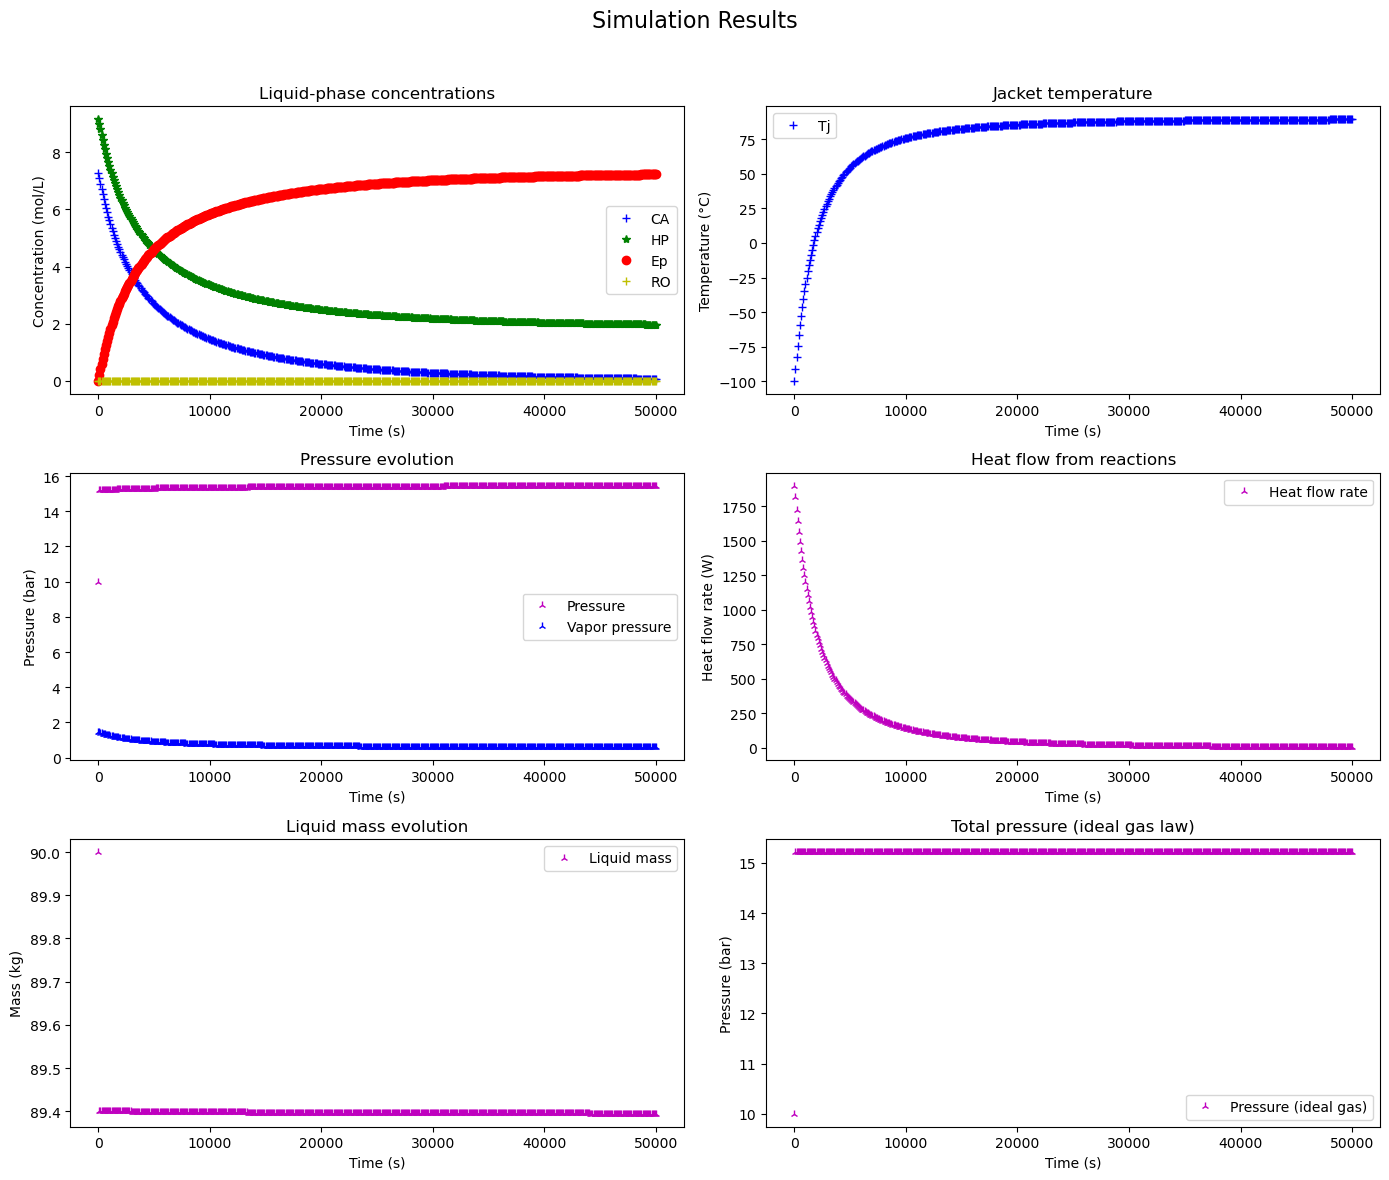

In [80]:
Tr0 = 90 + 273.15   # Temperature of the jacket or initial temperature
# Initial conditions
c0 = [7.26, 9.15, 0, 0, 7.41, 0, 0, 0,0,0,0,90,PN2] # CA0 HP0 Ep0 RO0 W0 O2_liq0 T0 nO2_gas0..., nCA_gas, nHP_gas, nEp_gas, nRO_gas, nW_gas, mr
t_span = (0, 50000) # from 0 to 50000 seconds 
t_eval = np.linspace(0, 50000, 501) # points at which to store the solution

# Solver
sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval)

# Extract solution
t = sol.t
CA_1 = sol.y[0]
HP_1 = sol.y[1]
Ep_1 = sol.y[2]
W_1 = sol.y[4]
RO_1 = sol.y[3]
O2_liq_1 = sol.y[5]
n02_gas_1 = sol.y[6]
nCA_gas_1 = sol.y[7]
nHP_gas_1 = sol.y[8]
nEp_gas_1 = sol.y[9]
nW_gas_1 = sol.y[10]
nN2_gas_1 = (PN2 * Vheadspace) / (Rg * Tr0) # N2 at t=0
mr_1=sol.y[11]
Pressure=sol.y[12]/100000

# Calculate Pressure considering the condition
P_1 = ((n02_gas_1 + nCA_gas_1 + nHP_gas_1 + nEp_gas_1 + nW_gas_1+ nN2_gas_1) * Rg * Tr0 / Vheadspace) / 100000

# Calculate Vapor pressure of the mixture using Raoult law
VP_W=(10**(11.008-(2239.7/Tr0)))
VP_HP=(10**(9.9669-(2175/Tr0)))
VP_CA=(10**(9.7621-(1511.9/Tr0)))
VP_Ep=(10**(10.671-(2182.2/Tr0)))
VP_Diol=(10**(12.266-(3455.4/Tr0)))
VP_mix=((W_1*VP_W+HP_1*VP_HP+CA_1*VP_CA+Ep_1*VP_Ep+RO_1*VP_Diol)/(W_1+HP_1+CA_1+Ep_1+RO_1+O2_liq_1))/100000 #Express in bar

# Rates
k1_T = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate1 = k1_T * CA_1 * HP_1
k2_T = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate2 = k2_T * (HP_1**2)
k3_T = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr0) - (1 / 373.15))))
rate3 = k3_T * Ep_1 * W_1
qrx=-rate1*H1*(mr_1/rho)-rate2*H2*(mr_1/rho)-rate3*H3*(mr_1/rho)
Tj=((qrx/(-UA))+Tr0)-273.15

#plot 

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Simulation Results", fontsize=16)

# Concentrations 
axs[0, 0].plot(t, CA_1, 'b+', label='CA')
axs[0, 0].plot(t, HP_1, 'g*', label='HP')
axs[0, 0].plot(t, Ep_1, 'ro', label='Ep')
axs[0, 0].plot(t, RO_1, 'y+', label='RO')
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Concentration (mol/L)")
axs[0, 0].set_title("Liquid-phase concentrations")
axs[0, 0].legend()

# Jacket temperature 
axs[0, 1].plot(t, Tj, 'b+', label='Tj')
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Temperature (°C)")
axs[0, 1].set_title("Jacket temperature")
axs[0, 1].legend()

# Pressure & vapor pressure 
axs[1, 0].plot(t, P_1, 'm2', label='Pressure')
axs[1, 0].plot(t, VP_mix, 'b2', label='Vapor pressure')
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Pressure (bar)")
axs[1, 0].set_title("Pressure evolution")
axs[1, 0].legend()

# Heat flow rate 
axs[1, 1].plot(t, qrx, 'm2', label='Heat flow rate')
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Heat flow rate (W)")
axs[1, 1].set_title("Heat flow from reactions")
axs[1, 1].legend()

# Liquid mass 
axs[2, 0].plot(t, mr_1, 'm2', label='Liquid mass')
axs[2, 0].set_xlabel("Time (s)")
axs[2, 0].set_ylabel("Mass (kg)")
axs[2, 0].set_title("Liquid mass evolution")
axs[2, 0].legend()

# Pressure (ideal gas law) 
axs[2, 1].plot(t, Pressure, 'm2', label='Pressure (ideal gas)')
axs[2, 1].set_xlabel("Time (s)")
axs[2, 1].set_ylabel("Pressure (bar)")
axs[2, 1].set_title("Total pressure (ideal gas law)")
axs[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


When we increased the initial temperature to $90°C$, the reaction rate is accelerated. HP decomposition becomes faster. As a consequence, we have more oxygen released. Thus, the pressure increases more comparing to the last simulation with $T_{r0} = 65°C$.

## Isoperibolic mode 

The same reaction system is used and the same thing as the kinetic and thermodynamics constants. In the previous section, $T_R$ was constant and now it is given by:

$$
\frac{d T_R}{dt}
=
\frac{
- R_1 \,\Delta H_{R,1}\, V_R
- R_2 \,\Delta H_{R,2}\, V_R
- R_3 \,\Delta H_{R,3}\, V_R
+ UA \left( T_j - T_R \right)
}{
m_R \, C_{p,R}
}
$$



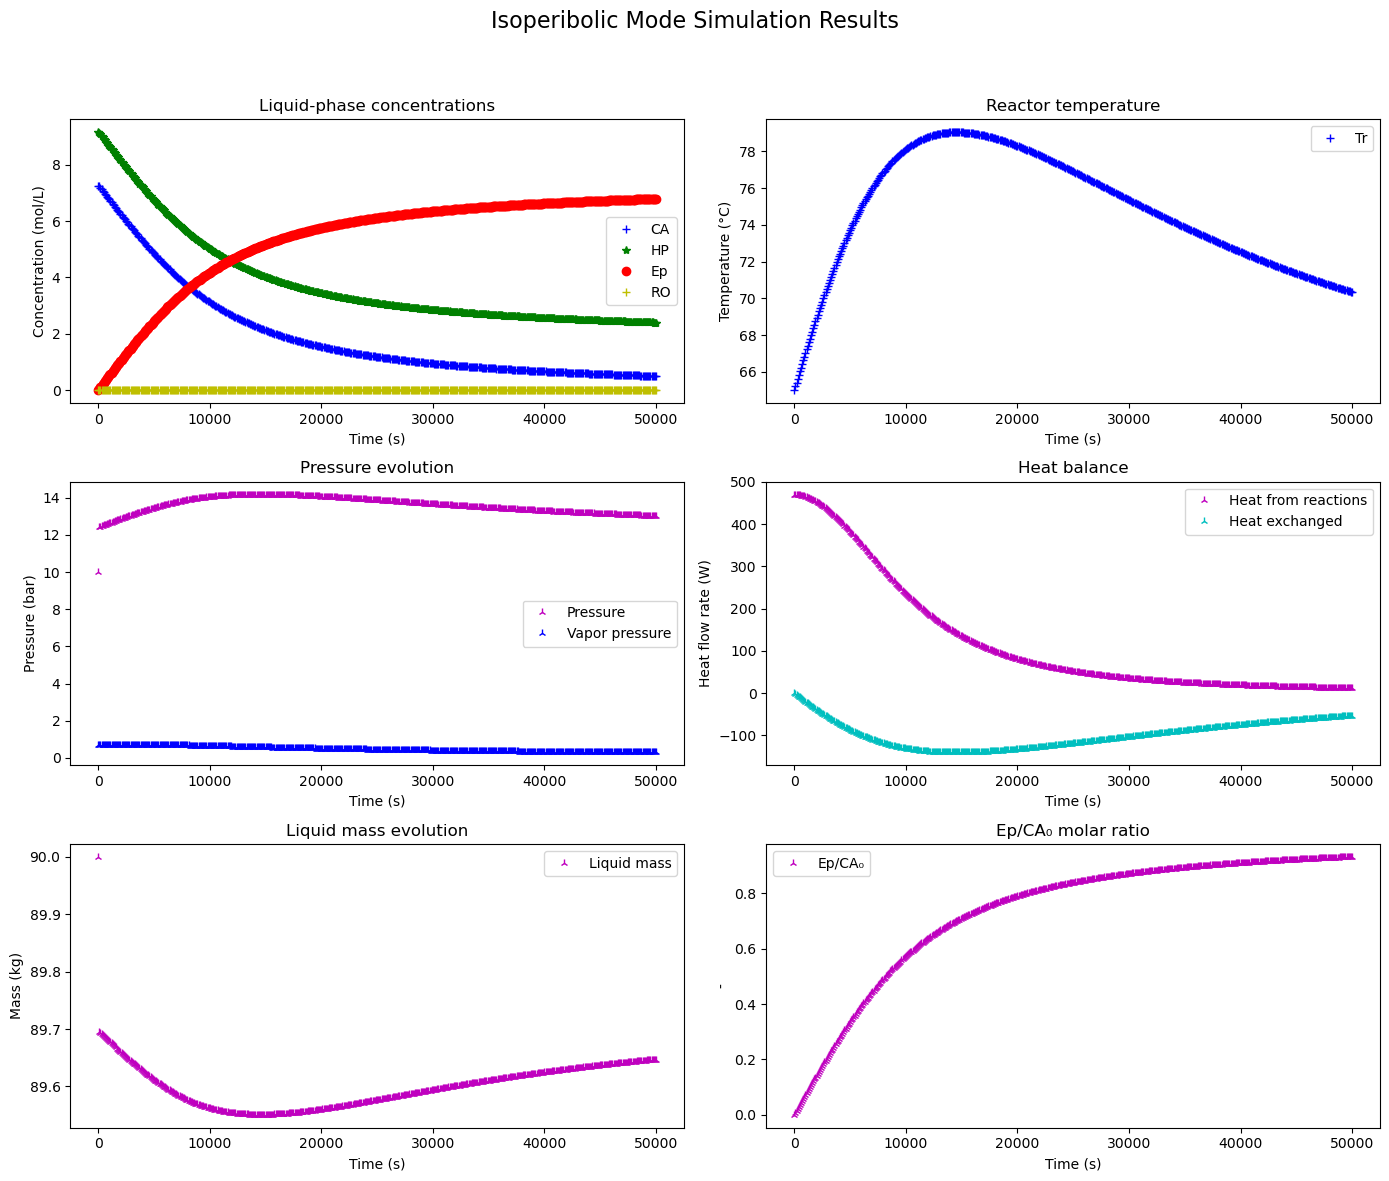

In [82]:
# Cste
Tr0 = 65 + 273.15   # Temperature of the jacket or initial temperature
Tj=Tr0
V0=mr/rho
kla2=3.5

# ODE definition 
def df(t, c):
    CA, HP, Ep, RO, W, O2_liq, n02_gas, nCA_gas, nHP_gas, nEp_gas, nW_gas, mr, Tr = c
    k1 = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr) - (1 / 373.15))))
    k2 = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr) - (1 / 373.15))))
    k3 = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr) - (1 / 373.15))))
    R1 = k1 * CA * HP
    R2 = k2 * (HP**2)
    R3 = k3 * Ep * W
    O2_star = 0.001473 * np.exp(-0.008492 * (Tr - 273.15))
    W_star_g=(10**(11.008-(2239.7/Tr)))/(Rg*Tr) #en mol/m3
    HP_star_g=(10**(9.9669-(2175/Tr)))/(Rg*Tr) #en mol/m3
    CA_star_g=(10**(9.7621-(1511.9/Tr)))/(Rg*Tr) #en mol/m3
    Ep_star_g=(10**(10.671-(2182.2/Tr)))/(Rg*Tr) #en mol/m3
    Diol_star_g=(10**(12.266-(3455.4/Tr)))/(Rg*Tr) #en mol/m3
    
    # Adjust kla based on O2_liq - O2_star condition
    kla_effective = kla if O2_liq - O2_star >= 0 else 0
    dO2_liqdt = R2 - kla_effective * (O2_liq - O2_star)
    dn02_gasdt = kla_effective * (mr / rho) * (O2_liq - O2_star)
    
    dCAdt = -R1-(kla2*(CA_star_g-nCA_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(CA/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dHPdt = -R1 - 2 * R2-(kla2*(HP_star_g-nHP_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(HP/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dEpdt = R1 - R3-(kla2*(Ep_star_g-nEp_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(Ep/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dROdt = R3-(RO/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dWdt = R1 + 2 * R2 - R3-(kla2*(W_star_g-nW_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(W/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    
    dnCA_gasdt=Vheadspace*kla2*(CA_star_g-nCA_gas/Vheadspace)
    dnHP_gasdt=Vheadspace*kla2*(HP_star_g-nHP_gas/Vheadspace)
    dnEp_gasdt=Vheadspace*kla2*(Ep_star_g-nEp_gas/Vheadspace)
    dnW_gasdt=Vheadspace*kla2*(W_star_g-nW_gas/Vheadspace)
    dmrdt=-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3))
    dTrdt = ((-R1 * (mr / rho) * H1) + (-R2 * (mr / rho) * H2) + (-R3 * (mr / rho) * H3) + UA * (Tj - Tr)) / (mr * Cpr)
    return [dCAdt, dHPdt, dEpdt, dROdt, dWdt, dO2_liqdt, dn02_gasdt, dnCA_gasdt, dnHP_gasdt, dnEp_gasdt, dnW_gasdt, dmrdt, dTrdt]

# Initial conditions
c0 = [7.26, 9.15, 0, 0, 7.41, 0, 0, 0,0,0,0,90,Tr0] # CA0 HP0 Ep0 RO0 W0 O2_liq0 T0 nO2_gas0..., nCA_gas, nHP_gas, nEp_gas, nRO_gas, nW_gas, mr
t_span = (0, 50000) # from 0 to 50000 seconds 
t_eval = np.linspace(0, 50000, 501) # points at which to store the solution

# Solver
sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval)

# Extract solution
t = sol.t
CA_1 = sol.y[0]
HP_1 = sol.y[1]
Ep_1 = sol.y[2]
W_1 = sol.y[4]
RO_1 = sol.y[3]
O2_liq_1 = sol.y[5]
n02_gas_1 = sol.y[6]
nCA_gas_1 = sol.y[7]
nHP_gas_1 = sol.y[8]
nEp_gas_1 = sol.y[9]
nW_gas_1 = sol.y[10]
nN2_gas_1 = (PN2 * Vheadspace) / (Rg * Tr0) # N2 at t=0
mr_1=sol.y[11]
Tr_1=sol.y[12]
Ratio_Ep_CA0=(Ep_1*(mr_1/rho))/(7.26*V0)

# Calculate Pressure considering the condition
P_1 = ((n02_gas_1 + nCA_gas_1 + nHP_gas_1 + nEp_gas_1 + nW_gas_1+ nN2_gas_1) * Rg * Tr_1 / Vheadspace) / 100000

# Calculate Vapor pressure of the mixture using Raoult law
VP_W=(10**(11.008-(2239.7/Tr_1)))
VP_HP=(10**(9.9669-(2175/Tr_1)))
VP_CA=(10**(9.7621-(1511.9/Tr_1)))
VP_Ep=(10**(10.671-(2182.2/Tr_1)))
VP_Diol=(10**(12.266-(3455.4/Tr_1)))
VP_mix=((W_1*VP_W+HP_1*VP_HP+CA_1*VP_CA+Ep_1*VP_Ep+RO_1*VP_Diol)/(W_1+HP_1+CA_1+Ep_1+RO_1+O2_liq_1))/100000 #Express in bar

# Rates
k1_T = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr_1) - (1 / 373.15))))
rate1 = k1_T * CA_1 * HP_1
k2_T = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr_1) - (1 / 373.15))))
rate2 = k2_T * (HP_1**2)
k3_T = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr_1) - (1 / 373.15))))
rate3 = k3_T * Ep_1 * W_1
qrx=-rate1*H1*(mr_1/rho)-rate2*H2*(mr_1/rho)-rate3*H3*(mr_1/rho)
qexch=UA*(Tj-Tr_1)

# Plot 
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Isoperibolic Mode Simulation Results", fontsize=16)

# Concentrations 
axs[0, 0].plot(t, CA_1, 'b+', label='CA')
axs[0, 0].plot(t, HP_1, 'g*', label='HP')
axs[0, 0].plot(t, Ep_1, 'ro', label='Ep')
axs[0, 0].plot(t, RO_1, 'y+', label='RO')
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Concentration (mol/L)")
axs[0, 0].set_title("Liquid-phase concentrations")
axs[0, 0].legend()

# Reactor temperature
axs[0, 1].plot(t, Tr_1 - 273.15, 'b+', label='Tr')
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Temperature (°C)")
axs[0, 1].set_title("Reactor temperature")
axs[0, 1].legend()

# Pressure & vapor pressure
axs[1, 0].plot(t, P_1, 'm2', label='Pressure')
axs[1, 0].plot(t, VP_mix, 'b2', label='Vapor pressure')
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Pressure (bar)")
axs[1, 0].set_title("Pressure evolution")
axs[1, 0].legend()

# Heat flow rates
axs[1, 1].plot(t, qrx, 'm2', label='Heat from reactions')
axs[1, 1].plot(t, qexch, 'c2', label='Heat exchanged')
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Heat flow rate (W)")
axs[1, 1].set_title("Heat balance")
axs[1, 1].legend()

# Liquid mass
axs[2, 0].plot(t, mr_1, 'm2', label='Liquid mass')
axs[2, 0].set_xlabel("Time (s)")
axs[2, 0].set_ylabel("Mass (kg)")
axs[2, 0].set_title("Liquid mass evolution")
axs[2, 0].legend()

# Ep/CA molar ratio
axs[2, 1].plot(t, Ratio_Ep_CA0, 'm2', label='Ep/CA₀')
axs[2, 1].set_xlabel("Time (s)")
axs[2, 1].set_ylabel("-")
axs[2, 1].set_title("Ep/CA₀ molar ratio")
axs[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The reactor temperature depends on the reaction heat generation and the heat removed by the jacket. Comparing to the isothermal mode, we have higher pressure as a consequence. 

### Evaporation effect in the thermal balance

In the previous sections, we showed how to consider the evolution of concentration, jacket and reaction temperature in isothermal and isoperiboloic modes, pressure, vapor pressure and liquid mass. In this section, we will implement the evaporation effect in the thermal balance which is given by: 

$$
\frac{d T_R}{dt}
=
\frac{
- R_1 \,\Delta H_{R,1}\, V_R
- R_2 \,\Delta H_{R,2}\, V_R
- R_3 \,\Delta H_{R,3}\, V_R
+ UA \left( T_j - T_R \right) - q_{evaporation}
}{
m_R \, C_{p,R}
}
$$

From this figure, we can determine the heat of evaporation or latent heat of vaporization for each component : 

![alt text](Enthalpies.png "Latent heat of vaporization for each compound")


#### The latent heat of vaporization:
$$
\Delta H_{vap,CA} = 28943 J/mol
$$

$$
\Delta H_{vap,W} = 42876 J/mol
$$

$$
\Delta H_{vap,Ep} = 41775 J/mol
$$

$$
\Delta H_{vap,HP} = 41638 J/mol
$$

$$
\Delta H_{vap,Diol} = 66149 J/mol
$$

The heat flow rate of evaporation can be calculated as:
$$
q_{evaporation} = \sum_i \dot n_{i,evap} \Delta H_{vap,i}
$$
where $\dot n_{i,evap} = K_{gas} . a . V_{gas} \left ( \frac{VP_i(T_{gas phase})}{Rg . T_{gas phase}} - C_{i,gas} \right) $ except for diol which is neglected.

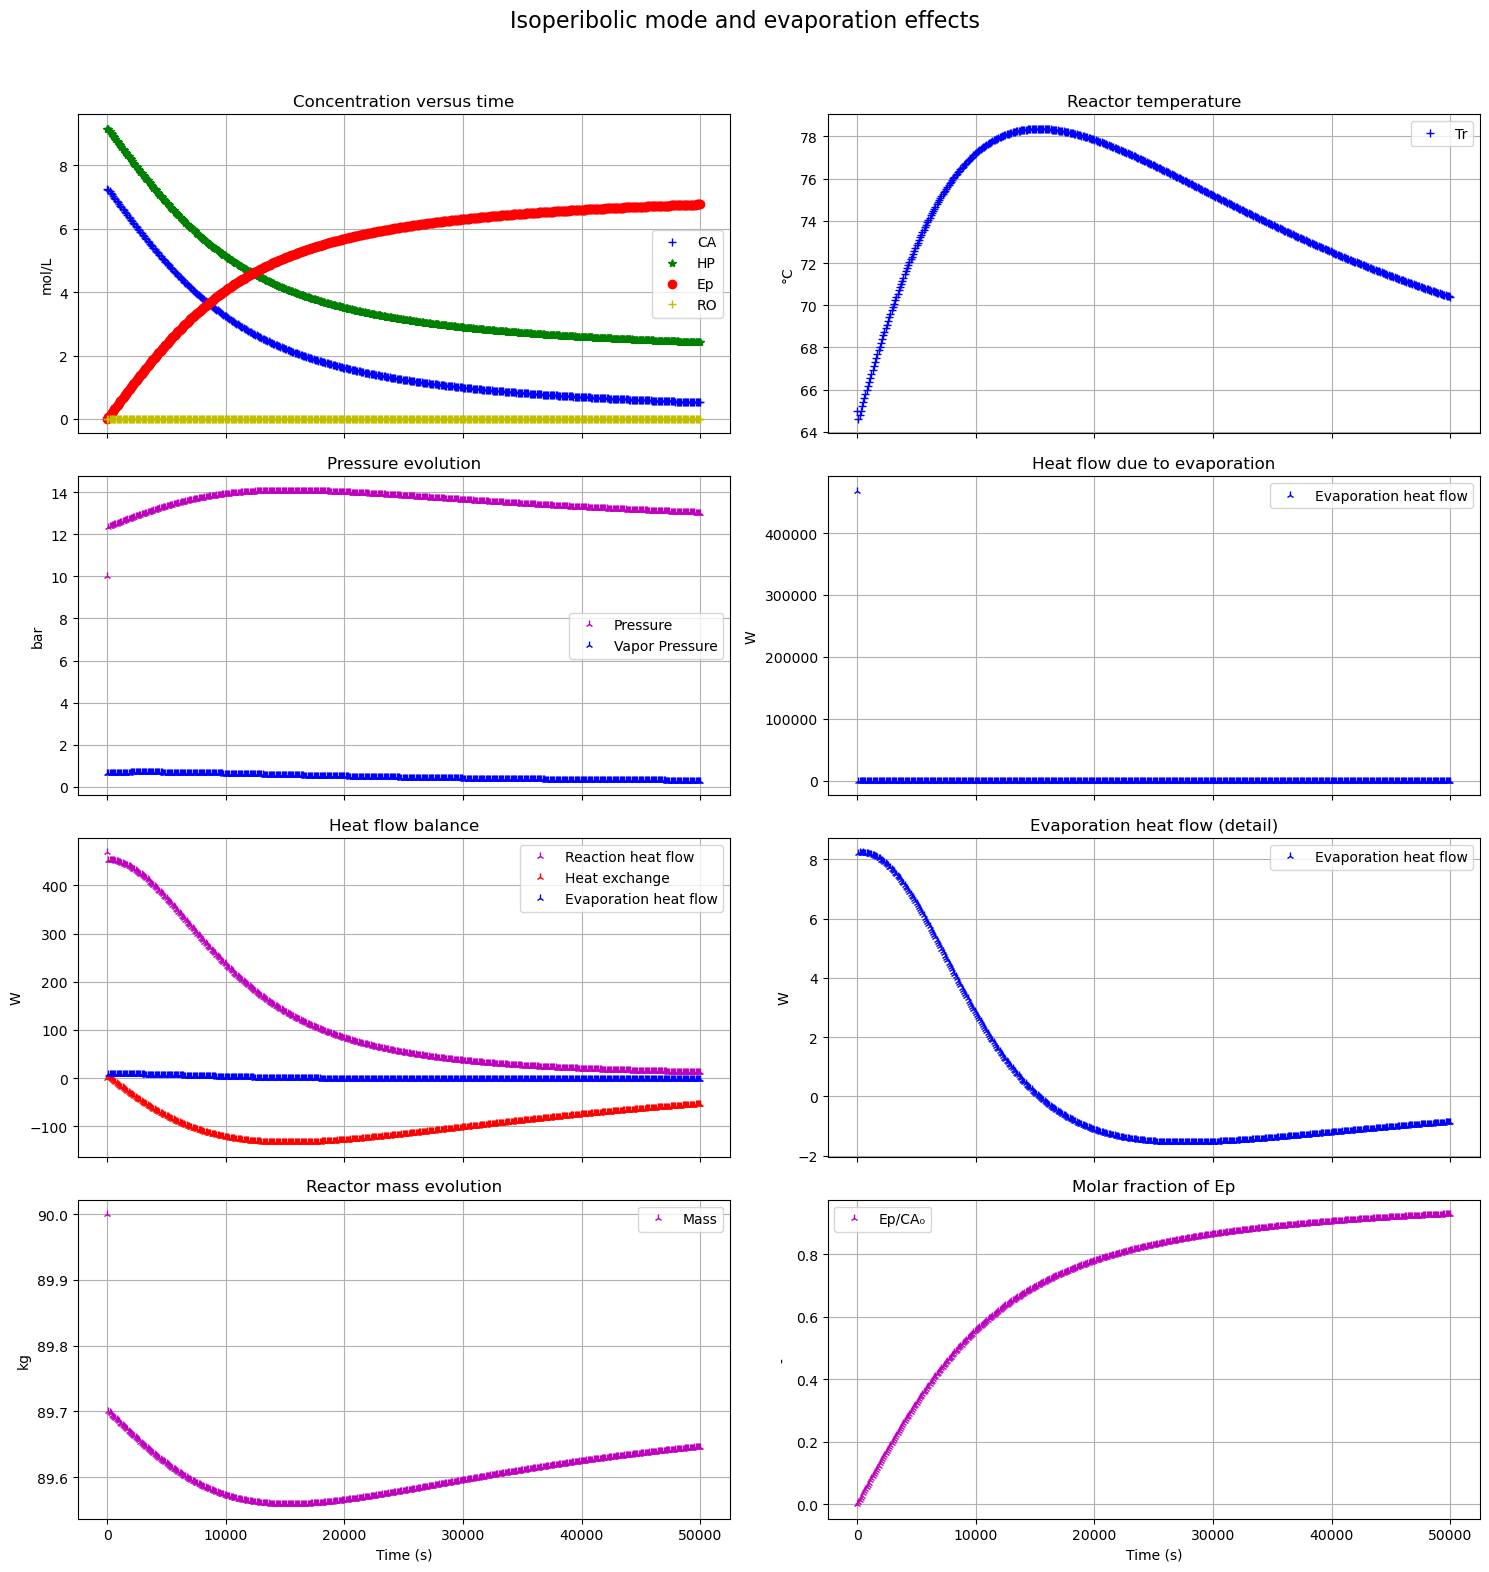

In [83]:
# Enthalpies of vaporization (J/mol)
Hvap_CA   = 28943
Hvap_W    = 42876
Hvap_Epi  = 41775
Hvap_HP   = 41638
Hvap_diol = 66149

# ODE definition 
def df(t, c):
    CA, HP, Ep, RO, W, O2_liq, n02_gas, nCA_gas, nHP_gas, nEp_gas, nW_gas, mr, Tr = c
    k1 = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr) - (1 / 373.15))))
    k2 = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr) - (1 / 373.15))))
    k3 = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr) - (1 / 373.15))))
    R1 = k1 * CA * HP
    R2 = k2 * (HP**2)
    R3 = k3 * Ep * W
    O2_star = 0.001473 * np.exp(-0.008492 * (Tr - 273.15))
    W_star_g=(10**(11.008-(2239.7/Tr)))/(Rg*Tr) #en mol/m3
    HP_star_g=(10**(9.9669-(2175/Tr)))/(Rg*Tr) #en mol/m3
    CA_star_g=(10**(9.7621-(1511.9/Tr)))/(Rg*Tr) #en mol/m3
    Ep_star_g=(10**(10.671-(2182.2/Tr)))/(Rg*Tr) #en mol/m3
    Diol_star_g=(10**(12.266-(3455.4/Tr)))/(Rg*Tr) #en mol/m3
    
    # Adjust kla based on O2_liq - O2_star condition
    kla_effective = kla if O2_liq - O2_star >= 0 else 0
    dO2_liqdt = R2 - kla_effective * (O2_liq - O2_star)
    dn02_gasdt = kla_effective * (mr / rho) * (O2_liq - O2_star)
    
    dCAdt = -R1-(kla2*(CA_star_g-nCA_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(CA/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dHPdt = -R1 - 2 * R2-(kla2*(HP_star_g-nHP_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(HP/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dEpdt = R1 - R3-(kla2*(Ep_star_g-nEp_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(Ep/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dROdt = R3-(RO/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    dWdt = R1 + 2 * R2 - R3-(kla2*(W_star_g-nW_gas/Vheadspace)/1000)*(Vheadspace/(mr/rho))-(W/mr)*(-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3)))
    
    dnCA_gasdt=Vheadspace*kla2*(CA_star_g-nCA_gas/Vheadspace)
    dnHP_gasdt=Vheadspace*kla2*(HP_star_g-nHP_gas/Vheadspace)
    dnEp_gasdt=Vheadspace*kla2*(Ep_star_g-nEp_gas/Vheadspace)
    dnW_gasdt=Vheadspace*kla2*(W_star_g-nW_gas/Vheadspace)
    dmrdt=-((kla_effective * (mr / rho) * (O2_liq - O2_star))*16E-3)-Vheadspace*(((kla2*(CA_star_g-nCA_gas/Vheadspace))*76.53E-3)+((kla2*(HP_star_g-nHP_gas/Vheadspace))*34E-3)+((kla2*(Ep_star_g-nEp_gas/Vheadspace)*92.53E-3))+((kla2*(W_star_g-nW_gas/Vheadspace))*18E-3))
    qevapo=Vheadspace*kla2*(CA_star_g-nCA_gas/Vheadspace)*Hvap_CA+Vheadspace*kla2*(HP_star_g-nHP_gas/Vheadspace)*Hvap_HP+Vheadspace*kla2*(Ep_star_g-nEp_gas/Vheadspace)*Hvap_Epi+Vheadspace*kla2*(W_star_g-nW_gas/Vheadspace)*Hvap_W
    dTrdt = ((-R1 * (mr / rho) * H1) + (-R2 * (mr / rho) * H2) + (-R3 * (mr / rho) * H3) + UA * (Tj - Tr)-qevapo) / (mr * Cpr)
    return [dCAdt, dHPdt, dEpdt, dROdt, dWdt, dO2_liqdt, dn02_gasdt, dnCA_gasdt, dnHP_gasdt, dnEp_gasdt, dnW_gasdt, dmrdt, dTrdt]

# Initial conditions
c0 = [7.26, 9.15, 0, 0, 7.41, 0, 0, 0,0,0,0,90,Tr0] # CA0 HP0 Ep0 RO0 W0 O2_liq0 T0 nO2_gas0..., nCA_gas, nHP_gas, nEp_gas, nRO_gas, nW_gas, mr
t_span = (0, 50000) # from 0 to 50000 seconds 
t_eval = np.linspace(0, 50000, 501) # points at which to store the solution

# Solver
sol = solve_ivp(df, t_span, c0, method='BDF', t_eval=t_eval,  max_step=10)

# Extract solution
t = sol.t
CA_1 = sol.y[0]
HP_1 = sol.y[1]
Ep_1 = sol.y[2]
W_1 = sol.y[4]
RO_1 = sol.y[3]
O2_liq_1 = sol.y[5]
n02_gas_1 = sol.y[6]
nCA_gas_1 = sol.y[7]
nHP_gas_1 = sol.y[8]
nEp_gas_1 = sol.y[9]
nW_gas_1 = sol.y[10]
nN2_gas_1 = (PN2 * Vheadspace) / (Rg * Tr0) # N2 at t=0
mr_1=sol.y[11]
Tr_1=sol.y[12]
Ratio_Ep_CA0=(Ep_1*(mr_1/rho))/(7.26*V0)
W_star_g_1=(10**(11.008-(2239.7/Tr_1)))/(Rg*Tr_1) #en mol/m3
HP_star_g_1=(10**(9.9669-(2175/Tr_1)))/(Rg*Tr_1) #en mol/m3
CA_star_g_1=(10**(9.7621-(1511.9/Tr_1)))/(Rg*Tr_1) #en mol/m3
Ep_star_g_1=(10**(10.671-(2182.2/Tr_1)))/(Rg*Tr_1) #en mol/m3
Diol_star_g_1=(10**(12.266-(3455.4/Tr_1)))/(Rg*Tr_1) #en mol/m3

# Calculate Pressure considering the condition
P_1 = ((n02_gas_1 + nCA_gas_1 + nHP_gas_1 + nEp_gas_1 + nW_gas_1+ nN2_gas_1) * Rg * Tr_1 / Vheadspace) / 100000

# Calculate Vapor pressure of the mixture using Raoult law
VP_W=(10**(11.008-(2239.7/Tr_1)))
VP_HP=(10**(9.9669-(2175/Tr_1)))
VP_CA=(10**(9.7621-(1511.9/Tr_1)))
VP_Ep=(10**(10.671-(2182.2/Tr_1)))
VP_Diol=(10**(12.266-(3455.4/Tr_1)))
VP_mix=((W_1*VP_W+HP_1*VP_HP+CA_1*VP_CA+Ep_1*VP_Ep+RO_1*VP_Diol)/(W_1+HP_1+CA_1+Ep_1+RO_1+O2_liq_1))/100000 #Express in bar

# Rates
k1_T = k01_100 * np.exp((-Ea1 / Rg) * (((1 / Tr_1) - (1 / 373.15))))
rate1 = k1_T * CA_1 * HP_1
k2_T = k02_100 * np.exp((-Ea2 / Rg) * (((1 / Tr_1) - (1 / 373.15))))
rate2 = k2_T * (HP_1**2)
k3_T = k03_100 * np.exp((-Ea3 / Rg) * (((1 / Tr_1) - (1 / 373.15))))
rate3 = k3_T * Ep_1 * W_1
qrx=-rate1*H1*(mr_1/rho)-rate2*H2*(mr_1/rho)-rate3*H3*(mr_1/rho)
qexch=UA*(Tj-Tr_1)
qevaporation=Vheadspace*kla2*(CA_star_g_1-nCA_gas_1/Vheadspace)*Hvap_CA+Vheadspace*kla2*(HP_star_g_1-nHP_gas_1/Vheadspace)*Hvap_HP+\
    Vheadspace*kla2*(Ep_star_g_1-nEp_gas_1/Vheadspace)*Hvap_Epi+Vheadspace*kla2*(W_star_g_1-nW_gas_1/Vheadspace)*Hvap_W

fig, axs = plt.subplots(4, 2, figsize=(15, 16), sharex=True)
fig.suptitle("Isoperibolic mode and evaporation effects", fontsize=16)

# Concentrations 
axs[0, 0].plot(t, CA_1, 'b+', label='CA')
axs[0, 0].plot(t, HP_1, 'g*', label='HP')
axs[0, 0].plot(t, Ep_1, 'ro', label='Ep')
axs[0, 0].plot(t, RO_1, 'y+', label='RO')
axs[0, 0].set_title("Concentration versus time")
axs[0, 0].set_ylabel("mol/L")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Temperature 
axs[0, 1].plot(t, Tr_1 - 273.15, 'b+', label='Tr')
axs[0, 1].set_title("Reactor temperature")
axs[0, 1].set_ylabel("°C")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Pressure 
axs[1, 0].plot(t, P_1, 'm2', label='Pressure')
axs[1, 0].plot(t, VP_mix, 'b2', label='Vapor Pressure')
axs[1, 0].set_title("Pressure evolution")
axs[1, 0].set_ylabel("bar")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Evaporation heat flow 
axs[1, 1].plot(t, qevaporation, 'b2', label='Evaporation heat flow')
axs[1, 1].set_title("Heat flow due to evaporation")
axs[1, 1].set_ylabel("W")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Global heat balance 
axs[2, 0].plot(t, qrx, 'm2', label='Reaction heat flow')
axs[2, 0].plot(t, qexch, 'r2', label='Heat exchange')
axs[2, 0].plot(t[1:], qevaporation[1:], 'b2', label='Evaporation heat flow')
axs[2, 0].set_title("Heat flow balance")
axs[2, 0].set_ylabel("W")
axs[2, 0].legend()
axs[2, 0].grid(True)

# Evaporation heat flow
axs[2, 1].plot(t[1:], qevaporation[1:], 'b2', label='Evaporation heat flow')
axs[2, 1].set_title("Evaporation heat flow (detail)")
axs[2, 1].set_ylabel("W")
axs[2, 1].legend()
axs[2, 1].grid(True)

# Reactor mass
axs[3, 0].plot(t, mr_1, 'm2', label='Mass')
axs[3, 0].set_title("Reactor mass evolution")
axs[3, 0].set_xlabel("Time (s)")
axs[3, 0].set_ylabel("kg")
axs[3, 0].legend()
axs[3, 0].grid(True)

# Molar ratio 
axs[3, 1].plot(t, Ratio_Ep_CA0, 'm2', label='Ep/CA₀')
axs[3, 1].set_title("Molar fraction of Ep")
axs[3, 1].set_xlabel("Time (s)")
axs[3, 1].set_ylabel("-")
axs[3, 1].legend()
axs[3, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

